# Sentiment Classification & Fake Review Detection on Amazon Reviews

## Objective
Develop an NLP system to classify customer review sentiment (positive/neutral/negative) and detect suspicious or fake reviews.

## Models
1. Machine Learning: Naive Bayes, Logistic Regression, Random Forest
2. Deep Learning: LSTM, CNN
3. Transformers: BERT/RoBERTa


In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

## 1. Data Loading and Analysis

In [ ]:
# Load Dataset
df = pd.read_csv('amazon_reviews.csv')
print("Dataset Loaded Successfully")
print("Shape:", df.shape)
print("Columns:", df.columns)
display(df.head())


# Basic Inspection
print("\nMissing Values:\n", df.isnull().sum())

Dataset Loaded Successfully
Shape: (10000, 11)
Columns: Index(['Unnamed: 0', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text'],
      dtype='object')


,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...



Missing Values:
 Unnamed: 0                0
Id                        0
ProductId                 0
UserId                    0
ProfileName               1
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64


## 2. Label Generation
Since the dataset lacks a ground-truth 'Fake' label, we will generate one using heuristics:
- **Duplicates**: Review text appearing more than once.
- **Length**: Extremely short reviews (< 5 words).
- **Unhelpfulness**: Reviews with many votes but low helpfulness ratio.

In [ ]:
#Target 1
df['sentiment_label'] = 0

for i in range(len(df)):
    score = str(df.loc[i, 'Score']).lower()

    if score == 'positive':
        df.loc[i, 'sentiment_label'] = 1
    else:
        df.loc[i, 'sentiment_label'] = 0


In [ ]:
# To Check duplicate texts
df['is_duplicate'] = df.duplicated(subset=['Text'], keep=False)


In [ ]:
# Count words in each review
df['word_count'] = 0

for i in range(len(df)):
    text = str(df.loc[i, 'Text'])
    df.loc[i, 'word_count'] = len(text.split())

# shorter
df['is_short'] = df['word_count'] < 5


In [ ]:
#calculating Helpless Ratio
df['help_ratio'] = 0.0

for i in range(len(df)):
    numerator = df.loc[i, 'HelpfulnessNumerator']
    denominator = df.loc[i, 'HelpfulnessDenominator']

    if denominator > 0:
        df.loc[i, 'help_ratio'] = numerator / denominator
    else:
        df.loc[i, 'help_ratio'] = 0


In [ ]:
#Identifying Unhelpful reviews
df['is_unhelpful'] = False

for i in range(len(df)):
    if df.loc[i, 'HelpfulnessDenominator'] > 5 and df.loc[i, 'help_ratio'] < 0.2:
        df.loc[i, 'is_unhelpful'] = True


In [ ]:
#Target 2 : Creation of Fake Reviews
df['is_fake'] = 0

for i in range(len(df)):
    if df.loc[i, 'is_duplicate'] or df.loc[i, 'is_short'] or df.loc[i, 'is_unhelpful']:
        df.loc[i, 'is_fake'] = 1
    else:
        df.loc[i, 'is_fake'] = 0


In [ ]:
#display results
print("Sentiment Distribution:")
print(df['sentiment_label'].value_counts())

print("\nFake Label Distribution:")
print(df['is_fake'].value_counts())


Sentiment Distribution:
sentiment_label
1    8321
0    1679
Name: count, dtype: int64

Fake Label Distribution:
is_fake
0    9062
1     938
Name: count, dtype: int64


## 3. Preprocessing

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower() #lowercase
    text = re.sub(r'<.*?>', '', text) #tags
    text = re.sub(r'http\S+', '', text) #urls
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(cleaned_tokens)

df['cleaned_text'] = df['Text'].apply(preprocess_text)
print("Preprocessing Complete.")
print(df[['Text', 'cleaned_text']].head())

Preprocessing Complete.
                                                Text  \
0  I have bought several of the Vitality canned d...   
1  Product arrived labeled as Jumbo Salted Peanut...   
2  This is a confection that has been around a fe...   
3  If you are looking for the secret ingredient i...   
4  Great taffy at a great price.  There was a wid...   

                                        cleaned_text  
0  bought several vitality canned dog food produc...  
1  product arrived labeled jumbo salted peanutsth...  
2  confection around century light pillowy citrus...  
3  looking secret ingredient robitussin believe f...  
4  great taffy great price wide assortment yummy ...  


## 4. Feature Extraction & Splitting

In [ ]:
X = df['cleaned_text']
y_sentiment = df['sentiment_label']
y_fake = df['is_fake']

# TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X)

#data split
X_train, X_test, y_sent_train, y_sent_test, y_fake_train, y_fake_test = train_test_split(
    X_tfidf, y_sentiment, y_fake, test_size=0.2, random_state=42
)

print("Train Shape:", X_train.shape)
print("Test Shape:", X_test.shape)

Train Shape: (8000, 5000)
Test Shape: (2000, 5000)


## 5. Machine Learning Models

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


### Sentiment Analyis
*Model Implementation



--- Naive Bayes (Sentiment) ---
              precision    recall  f1-score   support

           0       0.92      0.07      0.13       321
           1       0.85      1.00      0.92      1679

    accuracy                           0.85      2000
   macro avg       0.88      0.54      0.53      2000
weighted avg       0.86      0.85      0.79      2000

ROC-AUC Score: 0.9008310465174532


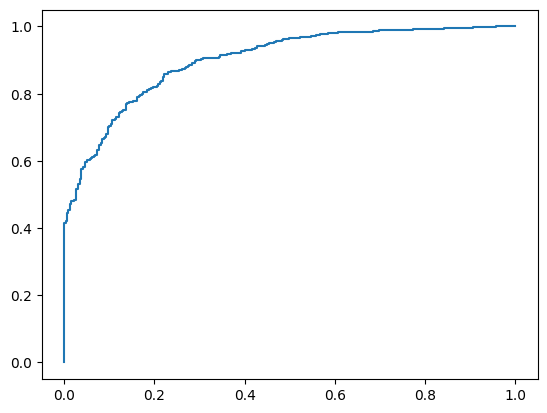

In [ ]:
#naive bayes

nb_model = MultinomialNB()
nb_model.fit(X_train, y_sent_train)

# Predictions
nb_pred = nb_model.predict(X_test)
nb_prob = nb_model.predict_proba(X_test)[:, 1]

# Results
print("Naive Bayes (Sentiment)")
print(classification_report(y_sent_test, nb_pred))
print("ROC-AUC Score:", roc_auc_score(y_sent_test, nb_prob))

# ROC Curve
fpr, tpr, _ = roc_curve(y_sent_test, nb_prob)
plt.plot(fpr, tpr, label="Naive Bayes")


--- Logistic Regression (Sentiment) ---
              precision    recall  f1-score   support

           0       0.90      0.35      0.50       321
           1       0.89      0.99      0.94      1679

    accuracy                           0.89      2000
   macro avg       0.90      0.67      0.72      2000
weighted avg       0.89      0.89      0.87      2000

ROC-AUC Score: 0.9356333227573896


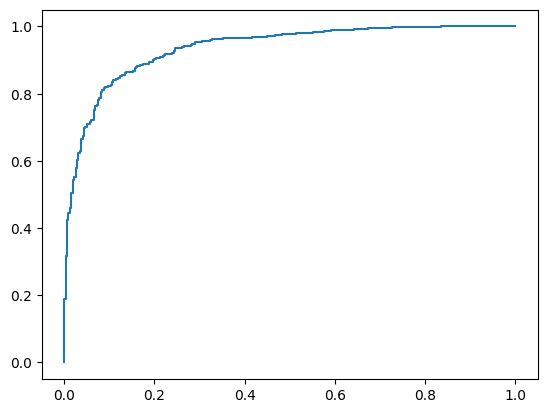

In [ ]:
#Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_sent_train)

# Predictions
lr_pred = lr_model.predict(X_test)
lr_prob = lr_model.predict_proba(X_test)[:, 1]

# Results
print("--- Logistic Regression (Sentiment) ---")
print(classification_report(y_sent_test, lr_pred))
print("ROC-AUC Score:", roc_auc_score(y_sent_test, lr_prob))

# ROC Curve
fpr, tpr, _ = roc_curve(y_sent_test, lr_prob)
plt.plot(fpr, tpr, label="Logistic Regression")


--- Random Forest (Sentiment) ---
              precision    recall  f1-score   support

           0       0.93      0.32      0.48       321
           1       0.89      1.00      0.94      1679

    accuracy                           0.89      2000
   macro avg       0.91      0.66      0.71      2000
weighted avg       0.89      0.89      0.86      2000

ROC-AUC Score: 0.9106982163763849


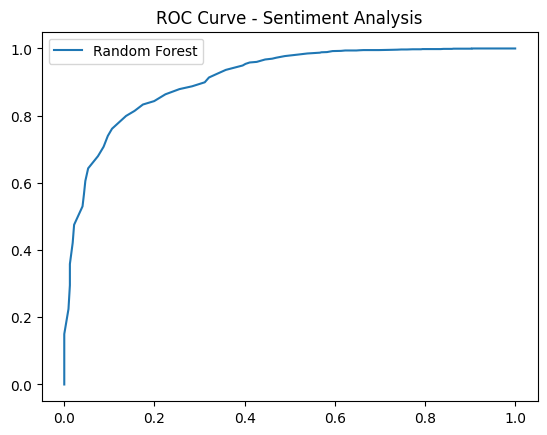

In [ ]:
#Random Forest
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_sent_train)

# Predictions
rf_pred = rf_model.predict(X_test)
rf_prob = rf_model.predict_proba(X_test)[:, 1]

# Results
print(" Random Forest (Sentiment)")
print(classification_report(y_sent_test, rf_pred))
print("ROC-AUC Score:", roc_auc_score(y_sent_test, rf_prob))

# ROC Curve
fpr, tpr, _ = roc_curve(y_sent_test, rf_prob)
plt.plot(fpr, tpr, label="Random Forest")
plt.title("ROC Curve - Sentiment Analysis")
plt.legend()
plt.show()


### Fake Review Detection

 FAKE REVIEW DETECTION RESULTS
 Naive Bayes (Fake Detection)
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1785
           1       0.98      0.24      0.39       215

    accuracy                           0.92      2000
   macro avg       0.95      0.62      0.67      2000
weighted avg       0.92      0.92      0.89      2000

Logistic Regression (Fake Detection)
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1785
           1       0.87      0.45      0.59       215

    accuracy                           0.93      2000
   macro avg       0.90      0.72      0.78      2000
weighted avg       0.93      0.93      0.92      2000

 Random Forest (Fake Detection)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1785
           1       0.97      0.80      0.87       215

    accuracy                           0.98      200

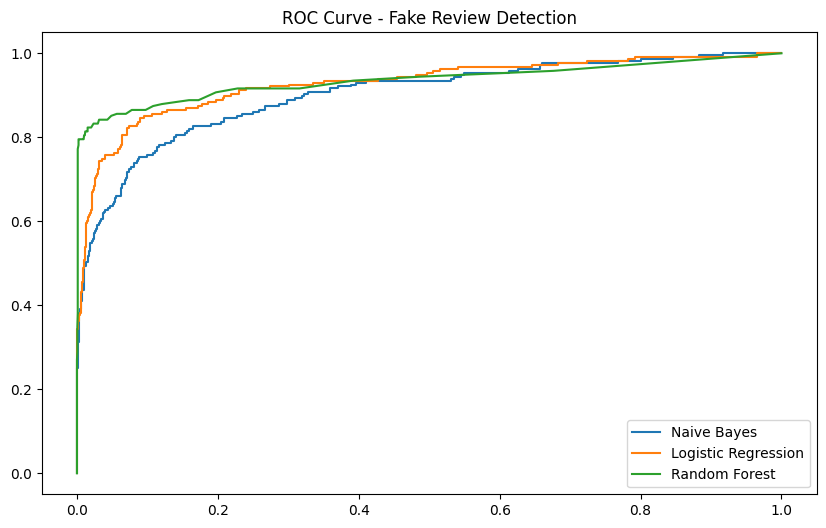

In [ ]:
plt.figure(figsize=(10, 6))
print(" FAKE REVIEW DETECTION RESULTS")

# Naive Bayes
nb_model.fit(X_train, y_fake_train)
nb_pred = nb_model.predict(X_test)
nb_prob = nb_model.predict_proba(X_test)[:, 1]
print(" Naive Bayes (Fake Detection)")
print(classification_report(y_fake_test, nb_pred))
plt.plot(*roc_curve(y_fake_test, nb_prob)[:2], label="Naive Bayes")

# Logistic Regression
lr_model.fit(X_train, y_fake_train)
lr_pred = lr_model.predict(X_test)
lr_prob = lr_model.predict_proba(X_test)[:, 1]
print("Logistic Regression (Fake Detection)")
print(classification_report(y_fake_test, lr_pred))
plt.plot(*roc_curve(y_fake_test, lr_prob)[:2], label="Logistic Regression")

# Random Forest
rf_model.fit(X_train, y_fake_train)
rf_pred = rf_model.predict(X_test)
rf_prob = rf_model.predict_proba(X_test)[:, 1]
print(" Random Forest (Fake Detection)")
print(classification_report(y_fake_test, rf_pred))
plt.plot(*roc_curve(y_fake_test, rf_prob)[:2], label="Random Forest")

plt.title("ROC Curve - Fake Review Detection")
plt.legend()
plt.show()


## 6. Deep Learning Models (LSTM & CNN)
We need to prepare text sequences for Deep Learning.

In [ ]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout


In [ ]:
#Tokeniztion and Padding
MAX_WORDS = 10000
MAX_LEN = 100

# create
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(df['cleaned_text'])

# text to sequences
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])

# Pad sequences
X_dl = pad_sequences(sequences, maxlen=MAX_LEN)


In [ ]:
from sklearn.model_selection import train_test_split

#for sentiment classification
X_train_dl, X_test_dl, y_sent_train_dl, y_sent_test_dl = train_test_split(
    X_dl,
    y_sentiment,
    test_size=0.2,
    random_state=42
)





In [ ]:
# Training LSTM Model for Sentiment

lstm_model = Sequential()

# Embedding layer
lstm_model.add(Embedding(MAX_WORDS, 128, input_length=MAX_LEN))

# LSTM layer
lstm_model.add(LSTM(64))

# reduce overfitting
lstm_model.add(Dropout(0.5))

# Output layer
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile model
lstm_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Train model
lstm_model.fit(
    X_train_dl,
    y_sent_train_dl,
    epochs=3,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)


Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 143ms/step - accuracy: 0.8122 - loss: 0.4996 - val_accuracy: 0.9013 - val_loss: 0.2732
Epoch 2/3
113/113 ━━━━━━━━━━━━━━━━━━━━ 22s 198ms/step - accuracy: 0.9225 - loss: 0.2177 - val_accuracy: 0.9013 - val_loss: 0.2604
Epoch 3/3
113/113 ━━━━━━━━━━━━━━━━━━━━ 29s 250ms/step - accuracy: 0.9622 - loss: 0.1104 - val_accuracy: 0.8988 - val_loss: 0.3086


In [ ]:
#Training CNN Model for Sentiment

cnn_model = Sequential()
cnn_model.add(Embedding(MAX_WORDS, 128, input_length=MAX_LEN))
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Train model
cnn_model.fit(
    X_train_dl,
    y_sent_train_dl,
    epochs=3,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)


Epoch 1/3
113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 194ms/step - accuracy: 0.8037 - loss: 0.5126 - val_accuracy: 0.8475 - val_loss: 0.3365
Epoch 2/3
113/113 ━━━━━━━━━━━━━━━━━━━━ 35s 145ms/step - accuracy: 0.8653 - loss: 0.2980 - val_accuracy: 0.8975 - val_loss: 0.2583
Epoch 3/3
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - accuracy: 0.9621 - loss: 0.1195 - val_accuracy: 0.8900 - val_loss: 0.2941


In [ ]:
# Training LSTM Model for Fake Review Detection

lstm_fake = Sequential()


lstm_fake.add(Embedding(MAX_WORDS, 128, input_length=MAX_LEN))

# LSTM layer
lstm_fake.add(LSTM(64))

# Dropout layer
lstm_fake.add(Dropout(0.5))

# Output layer
lstm_fake.add(Dense(1, activation='sigmoid'))

# Compile model
lstm_fake.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Train model
lstm_fake.fit(
    X_train_dl,
    y_fake_train_dl,
    epochs=3,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)


Epoch 1/3
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 148ms/step - accuracy: 0.8809 - loss: 0.4130 - val_accuracy: 0.9362 - val_loss: 0.1653
Epoch 2/3
113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 0.9506 - loss: 0.1428 - val_accuracy: 0.9675 - val_loss: 0.1162
Epoch 3/3
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.9807 - loss: 0.0669 - val_accuracy: 0.9688 - val_loss: 0.1099


In [ ]:
#Training CNN Model for Fake Review Detection

cnn_fake = Sequential()

# Embedding layer
cnn_fake.add(Embedding(MAX_WORDS, 128, input_length=MAX_LEN))

# Convolution layer
cnn_fake.add(Conv1D(128, 5, activation='relu'))

# pooling layer
cnn_fake.add(GlobalMaxPooling1D())
# fully connected layer
cnn_fake.add(Dense(64, activation='relu'))
cnn_fake.add(Dropout(0.5))

# Output layer
cnn_fake.add(Dense(1, activation='sigmoid'))
cnn_fake.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


cnn_fake.fit(
    X_train_dl,
    y_fake_train_dl,
    epochs=3,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)


Epoch 1/3
113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - accuracy: 0.8833 - loss: 0.3814 - val_accuracy: 0.9425 - val_loss: 0.1701
Epoch 2/3
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - accuracy: 0.9540 - loss: 0.1454 - val_accuracy: 0.9675 - val_loss: 0.1166
Epoch 3/3
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - accuracy: 0.9835 - loss: 0.0583 - val_accuracy: 0.9725 - val_loss: 0.1128


In [ ]:

lstm_loss, lstm_acc = lstm_fake.evaluate(X_test_dl, y_fake_test_dl)
print("LSTM Fake Review Accuracy:", lstm_acc)

cnn_loss, cnn_acc = cnn_fake.evaluate(X_test_dl, y_fake_test_dl)
print("CNN Fake Review Accuracy:", cnn_acc)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9574 - loss: 0.1470
LSTM Fake Review Accuracy: 0.9555000066757202
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9664 - loss: 0.1481
CNN Fake Review Accuracy: 0.9614999890327454


## 7. Transformer Models (BERT)


Sentiment

In [ ]:
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split

# Train-test split
X_text_train, X_text_test, y_sent_train_bert, y_sent_test_bert = train_test_split(
    df['cleaned_text'],
    y_sentiment,
    test_size=0.2,
    random_state=42
)

# Load tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

MAX_LEN = 100

# Encode training data
input_ids_train = []
attention_masks_train = []

for text in X_text_train:
    encoded = bert_tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        truncation=True,
        return_attention_mask=True
    )
    input_ids_train.append(encoded['input_ids'])
    attention_masks_train.append(encoded['attention_mask'])

X_train_bert = [
    np.array(input_ids_train),
    np.array(attention_masks_train)
]

# Encode test data
input_ids_test = []
attention_masks_test = []

for text in X_text_test:
    encoded = bert_tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        truncation=True,
        return_attention_mask=True
    )
    input_ids_test.append(encoded['input_ids'])
    attention_masks_test.append(encoded['attention_mask'])

X_test_bert = [
    np.array(input_ids_test),
    np.array(attention_masks_test)
]

# Load BERT model
bert_model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=1,
    from_pt=True,
    use_safetensors=False
)




bert_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"]
)



print("BERT model ready for training")


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT model ready for training


63/63 [==============================] - 902s 14s/step
Confusion Matrix (Sentiment):
 [[ 138  183]
 [ 661 1018]]


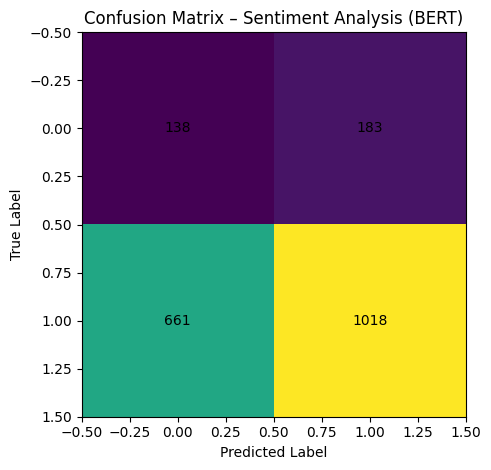


Classification Report (Sentiment):
              precision    recall  f1-score   support

    Negative       0.17      0.43      0.25       321
    Positive       0.85      0.61      0.71      1679

    accuracy                           0.58      2000
   macro avg       0.51      0.52      0.48      2000
weighted avg       0.74      0.58      0.63      2000



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np


y_pred_sent_logits = bert_model.predict(X_test_bert).logits

y_pred_sent = (tf.sigmoid(y_pred_sent_logits).numpy().flatten() > 0.5).astype(int)

# Confusion Matrix
cm_sent = confusion_matrix(y_sent_test_bert, y_pred_sent)
plt.figure()
plt.imshow(cm_sent)
plt.title("Confusion Matrix – Sentiment Analysis (BERT)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
print("Confusion Matrix (Sentiment):\n", cm_sent)
for i in range(cm_sent.shape[0]):
    for j in range(cm_sent.shape[1]):
        plt.text(j, i, cm_sent[i, j],
                 ha="center", va="center")

plt.tight_layout()
plt.show()

# Precision, Recall, F1
print("\nClassification Report (Sentiment):")
print(classification_report(
    y_sent_test_bert,
    y_pred_sent,
    target_names=["Negative", "Positive"]
))


In [ ]:
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split

# Train-test split
X_text_train, X_text_test, y_fake_train_bert, y_fake_test_bert = train_test_split(
    df['cleaned_text'],
    y_fake,
    test_size=0.2,
    random_state=42
)

# Load tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

MAX_LEN = 100

# Encode training data
input_ids_train = []
attention_masks_train = []

for text in X_text_train:
    encoded = bert_tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        truncation=True,
        return_attention_mask=True
    )
    input_ids_train.append(encoded['input_ids'])
    attention_masks_train.append(encoded['attention_mask'])

X_train_bert = [
    np.array(input_ids_train),
    np.array(attention_masks_train)
]

# Encode test data
input_ids_test = []
attention_masks_test = []

for text in X_text_test:
    encoded = bert_tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        truncation=True,
        return_attention_mask=True
    )
    input_ids_test.append(encoded['input_ids'])
    attention_masks_test.append(encoded['attention_mask'])

X_test_bert = [
    np.array(input_ids_test),
    np.array(attention_masks_test)
]

# Load BERT model
bert_model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=1,
    from_pt=True,
    use_safetensors=False
)



bert_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"]
)



print(" BERT model ready for FAKE REVIEW detection")


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 BERT model ready for FAKE REVIEW detection


63/63 [==============================] - 903s 14s/step


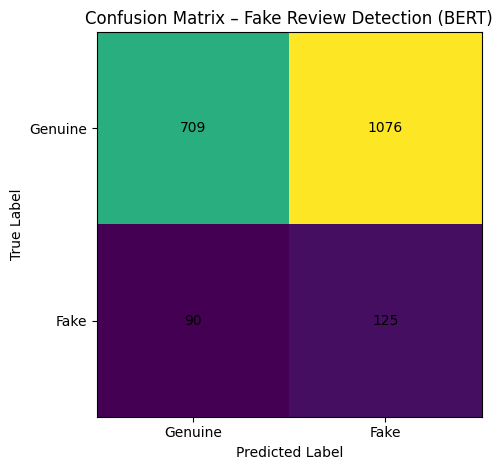

Confusion Matrix (Fake Review):
 [[ 709 1076]
 [  90  125]]

Classification Report (Fake Review):
              precision    recall  f1-score   support

     Genuine       0.89      0.40      0.55      1785
        Fake       0.10      0.58      0.18       215

    accuracy                           0.42      2000
   macro avg       0.50      0.49      0.36      2000
weighted avg       0.80      0.42      0.51      2000



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
# Predict logits
y_pred_fake_logits = bert_model.predict(X_test_bert).logits

y_pred_fake = (tf.sigmoid(y_pred_fake_logits).numpy().flatten() > 0.5).astype(int)

# Confusion Matrix
cm_fake = confusion_matrix(y_fake_test_bert, y_pred_fake)
plt.figure()
plt.imshow(cm_fake)
plt.title("Confusion Matrix – Fake Review Detection (BERT)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")


plt.xticks([0, 1], ["Genuine", "Fake"])
plt.yticks([0, 1], ["Genuine", "Fake"])


for i in range(cm_fake.shape[0]):
    for j in range(cm_fake.shape[1]):
        plt.text(j, i, cm_fake[i, j],
                 ha="center", va="center")

plt.tight_layout()
plt.show()
print("Confusion Matrix (Fake Review):\n", cm_fake)

# Precision, Recall, F1
print("\nClassification Report (Fake Review):")
print(classification_report(
    y_fake_test_bert,
    y_pred_fake,
    target_names=["Genuine", "Fake"]
))
